In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [39]:
data_dir = r'../data/raw/set-a/set-a'
outcomes_path = r'../data/raw/Outcomes-a.txt'


In [ ]:

# Load outcomes
outcomes_df = pd.read_csv(outcomes_path)
outcomes_df.set_index('RecordID', inplace=True)

# Define static + dynamic feature containers
all_dynamic_features = set()
all_static_features = set()

# From outcomes
outcome_static_features = set(outcomes_df.columns) - {'RecordID'}
static_params = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']
all_static_features.update(static_params)
all_static_features.update(outcome_static_features)


# Detect All Dynamic Feature Names from Raw Files

In [41]:
# Loop through all patient files and collect feature names
for file in os.listdir(data_dir):
    if file.endswith('.txt'):
        df = pd.read_csv(os.path.join(data_dir, file))
        all_params = df['Parameter'].unique()
        all_dynamic_features.update(all_params)

# Remove static features from dynamic list
all_dynamic_features = all_dynamic_features - all_static_features

# Sort both sets for consistency
all_static_features = sorted(all_static_features)
all_dynamic_features = sorted(all_dynamic_features)


In [42]:
static_data = []
dynamic_data = []

for file in os.listdir(data_dir):
    if file.endswith('.txt'):
        path = os.path.join(data_dir, file)
        df = pd.read_csv(path)

        # Extract RecordID
        rid = int(df[df['Parameter'] == 'RecordID']['Value'].values[0])
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

        # STATIC
        static_subset = df[df['Parameter'].isin(all_static_features)]
        static_dict = static_subset.drop_duplicates('Parameter').set_index('Parameter')['Value'].to_dict()
        static_dict['RecordID'] = rid
        static_data.append(static_dict)

        # DYNAMIC
        dynamic_subset = df[df['Parameter'].isin(all_dynamic_features)].copy()
        dynamic_subset['RecordID'] = rid
        dynamic_data.append(dynamic_subset)

# Create DataFrames
static_features_df = pd.DataFrame(static_data)
dynamic_features_df = pd.concat(dynamic_data, ignore_index=True)


In [43]:
print("Static Features DataFrame:")
print(static_features_df.shape)
display(static_features_df.head())

print("\n Dynamic Features DataFrame:")
print(dynamic_features_df.shape)
display(dynamic_features_df.head())


Static Features DataFrame:
(4000, 6)


,RecordID,Age,Gender,Height,ICUType,Weight
0,132539,54.0,0.0,-1.0,4.0,-1.0
1,132540,76.0,1.0,175.3,2.0,76.0
2,132541,44.0,0.0,-1.0,3.0,56.7
3,132543,68.0,1.0,180.3,3.0,84.6
4,132545,88.0,0.0,-1.0,3.0,-1.0



 Dynamic Features DataFrame:
(1608815, 4)


,Time,Parameter,Value,RecordID
0,00:07,GCS,15.00,132539
1,00:07,HR,73.00,132539
2,00:07,NIDiasABP,65.00,132539
3,00:07,NIMAP,92.33,132539
4,00:07,NISysABP,147.00,132539


# Distribution of Static Features (Age, Weight, ICUType)

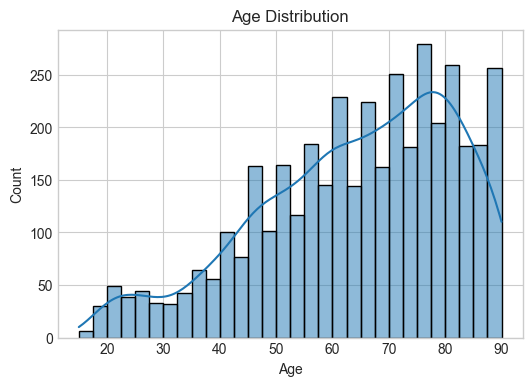

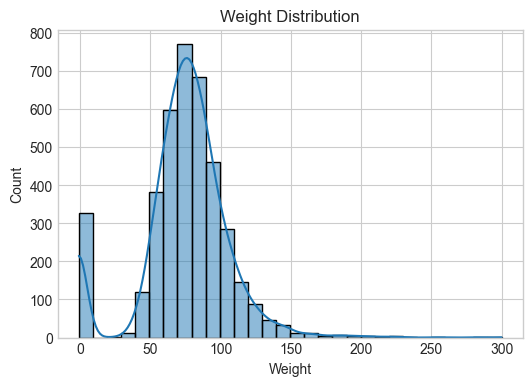

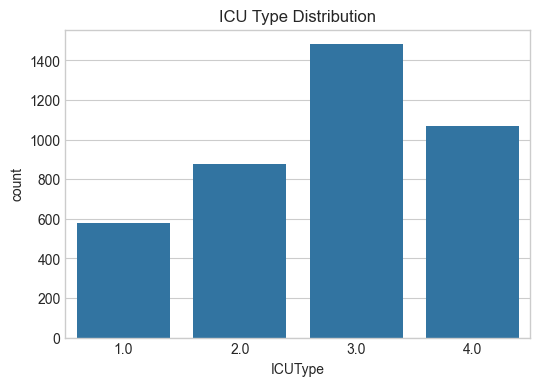

In [ ]:
# Age
plt.figure(figsize=(6, 4))
sns.histplot(static_features_df['Age'], kde=True, bins=30)
plt.title('Age Distribution')
plt.show()

# Weight
plt.figure(figsize=(6, 4))
sns.histplot(static_features_df['Weight'], kde=True, bins=30)
plt.title('Weight Distribution')
plt.show()

# ICU Type
plt.figure(figsize=(6, 4))
sns.countplot(x='ICUType', data=static_features_df)
plt.title('ICU Type Distribution')
plt.show()


# Distribution of Time Points per Patient

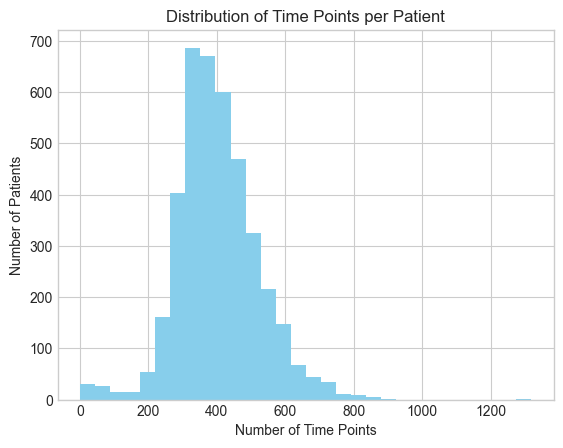

In [45]:
# Number of time points per patient
time_points = dynamic_features_df.groupby('RecordID')['Time'].count()
plt.hist(time_points, bins=30, color='skyblue')
plt.title("Distribution of Time Points per Patient")
plt.xlabel("Number of Time Points")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()


# Plot Mortality Class Distribution

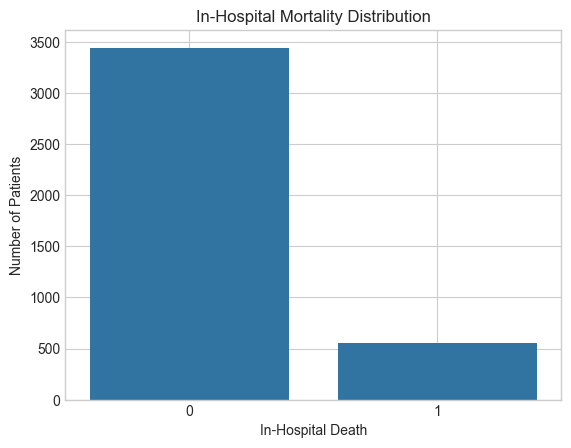

In [ ]:
# Reset index for plotting
outcomes_plot_df = outcomes_df.reset_index()

# Plot
sns.countplot(x='In-hospital_death', data=outcomes_plot_df)
plt.title("In-Hospital Mortality Distribution")
plt.xlabel("In-Hospital Death")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()


# Line Plot of Key Parameters Over Time

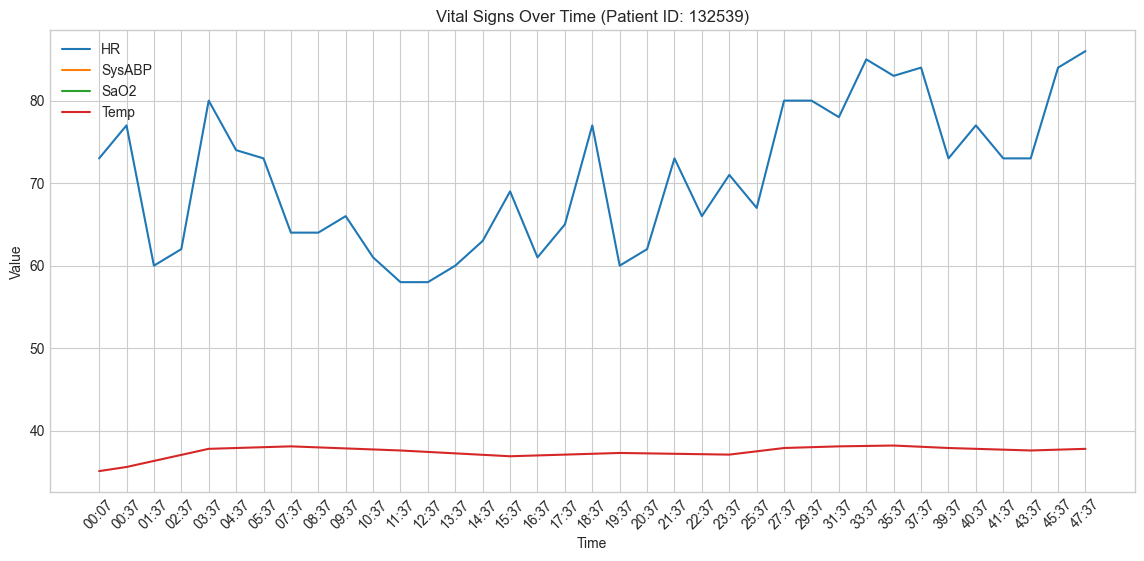

In [47]:
# Choose sample patient
sample_id = dynamic_features_df['RecordID'].unique()[0]
sample_df = dynamic_features_df[dynamic_features_df['RecordID'] == sample_id]

plt.figure(figsize=(14, 6))
for param in ['HR', 'SysABP', 'SaO2', 'Temp']:
    subset = sample_df[sample_df['Parameter'] == param]
    plt.plot(subset['Time'], subset['Value'], label=param)

plt.title(f"Vital Signs Over Time (Patient ID: {sample_id})")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Parameter Frequency Plot

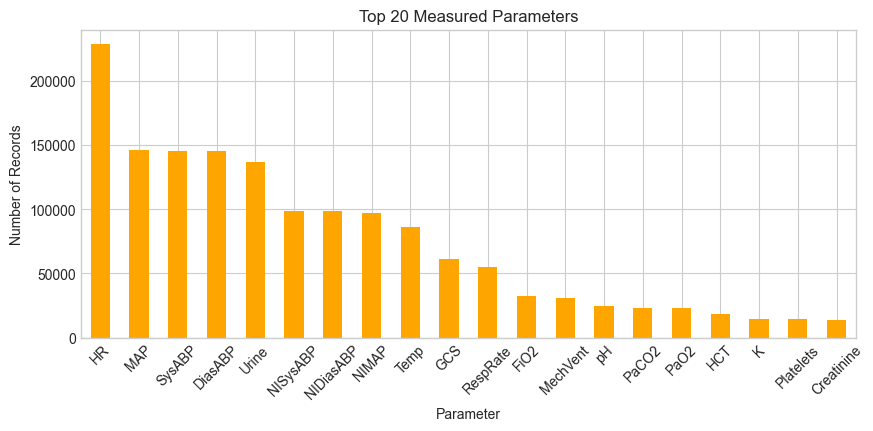

In [48]:
# Frequency of parameters measured
param_counts = dynamic_features_df['Parameter'].value_counts().sort_values(ascending=False)[:20]
param_counts.plot(kind='bar', figsize=(10, 4), color='orange')
plt.title("Top 20 Measured Parameters")
plt.ylabel("Number of Records")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Mortality by ICUType

C:\Users\jegullin\AppData\Local\Temp\ipykernel_44740\861181058.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged, x='ICUType', y='In-hospital_death', ci=None)


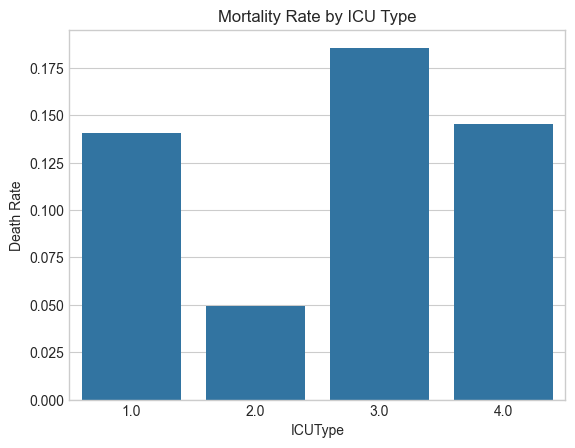

In [49]:
merged = static_features_df.merge(outcomes_df.reset_index(), on='RecordID')
sns.barplot(data=merged, x='ICUType', y='In-hospital_death', ci=None)
plt.title('Mortality Rate by ICU Type')
plt.ylabel('Death Rate')
plt.show()


# Plot Time Series for One Sample Patient

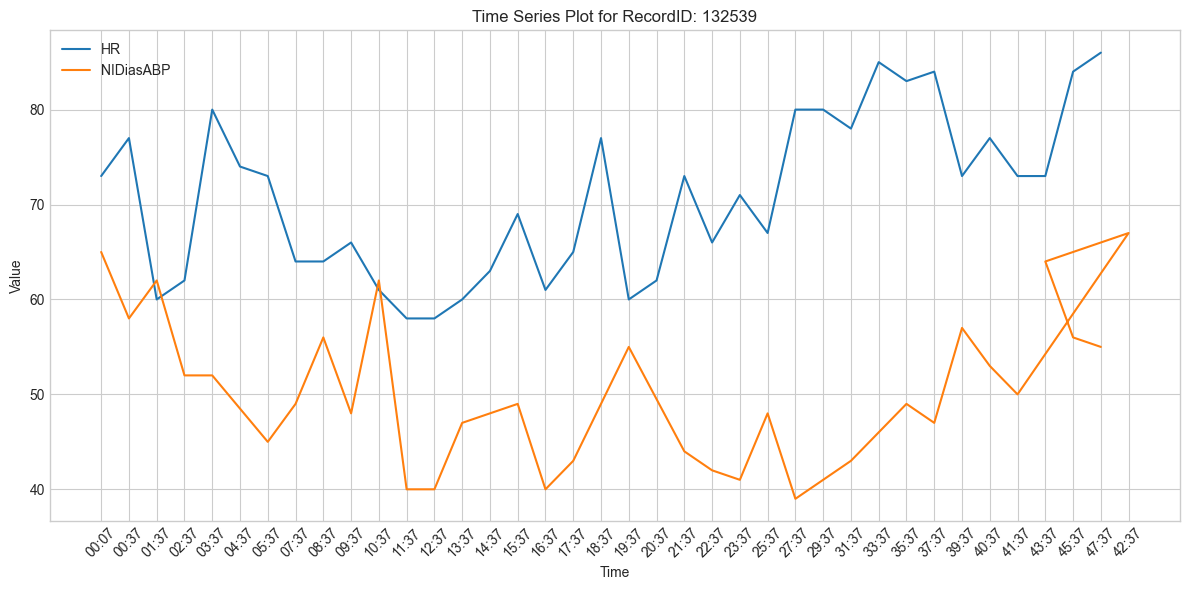

In [50]:
# Pick one random patient
sample_id = dynamic_features_df['RecordID'].unique()[0]
sample_df = dynamic_features_df[dynamic_features_df['RecordID'] == sample_id]

# Pick a few key variables to plot (if they exist)
variables_to_plot = ['HR', 'SysABP', 'NIDiasABP', 'SpO2']

plt.figure(figsize=(12, 6))
for var in variables_to_plot:
    if var in sample_df['Parameter'].unique():
        var_df = sample_df[sample_df['Parameter'] == var]
        plt.plot(var_df['Time'], var_df['Value'], label=var)

plt.title(f'Time Series Plot for RecordID: {sample_id}')
plt.xlabel("Time")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Boxplots of Key Dynamic Parameters by Outcome

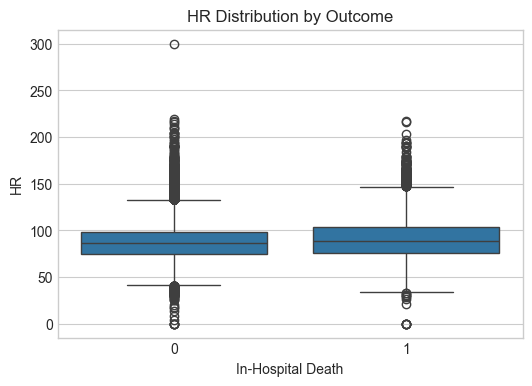

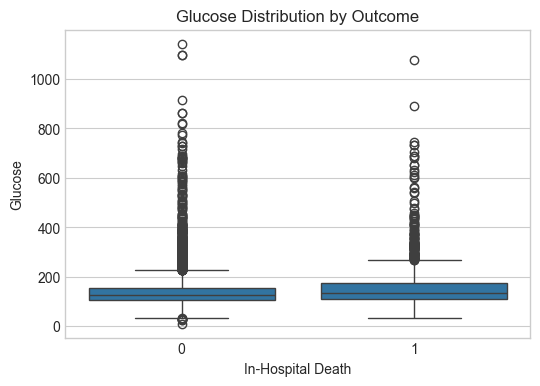

In [51]:
# Merge for plotting
plot_df = dynamic_features_df.merge(outcomes_df.reset_index(), on='RecordID')

# Choose parameters to compare
for param in ['HR', 'Glucose', 'SpO2']:
    if param in plot_df['Parameter'].unique():
        plt.figure(figsize=(6, 4))
        sns.boxplot(
            data=plot_df[plot_df['Parameter'] == param],
            x='In-hospital_death', y='Value'
        )
        plt.title(f'{param} Distribution by Outcome')
        plt.xlabel('In-Hospital Death')
        plt.ylabel(param)
        plt.show()


# Missing Data Ratio by Dynamic Variable

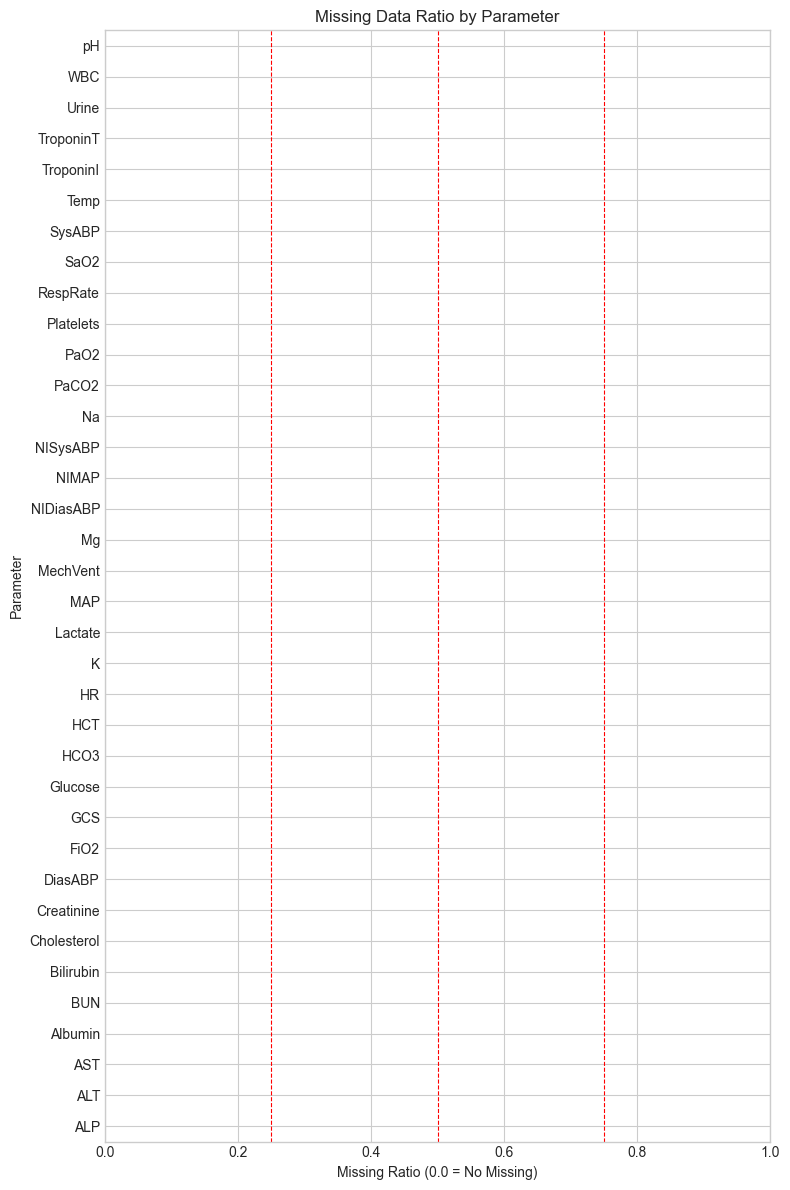

In [ ]:
# Calculate missing value ratio per dynamic parameter
missing_ratio = (
    dynamic_features_df
    .groupby('Parameter')['Value']
    .apply(lambda x: x.isnull().mean())
    .sort_values(ascending=True)
)

# Plot with visibility
plt.figure(figsize=(8, 12))
missing_ratio.plot(kind='barh', color='skyblue')

plt.title('Missing Data Ratio by Parameter')
plt.xlabel('Missing Ratio (0.0 = No Missing)')
plt.xlim(0, 1)  # Force x-axis from 0 to 1

# Add lines to show 25%, 50%, 75% thresholds
for x in [0.25, 0.5, 0.75]:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=0.8)

plt.grid(True)
plt.tight_layout()
plt.show()



# Correlation Heatmap of Static Features

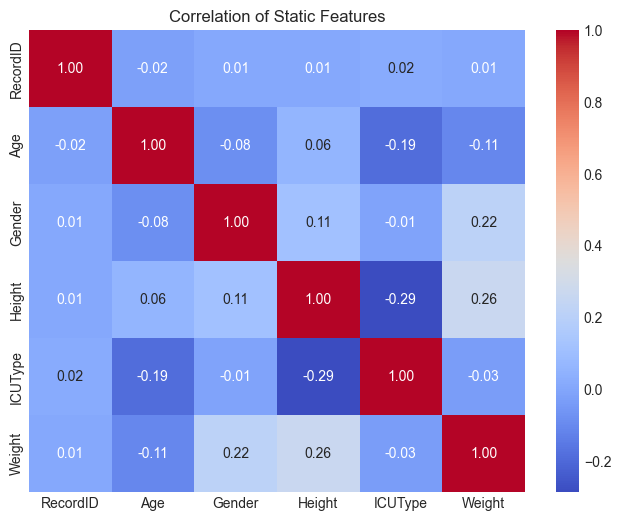

In [53]:
plt.figure(figsize=(8, 6))
sns.heatmap(static_features_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Static Features')
plt.show()


# Aggregate Time-Series Features Per Patient

In [54]:
# Aggregate time series features: mean, std, min, max per patient and parameter
aggregated_df = (
    dynamic_features_df
    .groupby(['RecordID', 'Parameter'])['Value']
    .agg(['mean', 'std', 'min', 'max'])
    .reset_index()
)

# Pivot so each parameter_stat becomes a column
aggregated_df = aggregated_df.pivot_table(
    index='RecordID',
    columns='Parameter',
    values=['mean', 'std', 'min', 'max']
)

# Flatten multi-index columns
aggregated_df.columns = [f'{stat}_{param}' for stat, param in aggregated_df.columns]
aggregated_df.reset_index(inplace=True)


# Merge Aggregated Dynamic + Static Features + Outcome

In [55]:
# Merge static + aggregated dynamic features
merged_df = pd.merge(static_features_df, aggregated_df, on='RecordID', how='inner')

# Merge in the label (In-hospital_death)
outcomes_clean = outcomes_df.reset_index()[['RecordID', 'In-hospital_death']]
final_df = pd.merge(merged_df, outcomes_clean, on='RecordID', how='inner')

# Preview final dataset
print(" Final DataFrame shape:", final_df.shape)
display(final_df.head())


 Final DataFrame shape: (3997, 151)


,RecordID,Age,Gender,Height,ICUType,Weight,max_ALP,max_ALT,max_AST,max_Albumin,...,std_RespRate,std_SaO2,std_SysABP,std_Temp,std_TroponinI,std_TroponinT,std_Urine,std_WBC,std_pH,In-hospital_death
0,132539,54.0,0.0,-1.0,4.0,-1.0,NaN,NaN,NaN,NaN,...,3.216898,NaN,NaN,0.935385,NaN,NaN,171.870307,1.272792,NaN,0
1,132540,76.0,1.0,175.3,2.0,76.0,NaN,NaN,NaN,NaN,...,NaN,2.041241,16.338979,0.986234,NaN,NaN,161.509760,3.350124,0.037796,0
2,132541,44.0,0.0,-1.0,3.0,56.7,127.0,91.0,235.0,2.7,...,NaN,NaN,12.153017,0.642112,NaN,NaN,93.216670,1.322876,0.017321,0
3,132543,68.0,1.0,180.3,3.0,84.6,105.0,12.0,15.0,4.4,...,3.410542,NaN,NaN,0.490160,NaN,NaN,224.953699,1.873499,NaN,0
4,132545,88.0,0.0,-1.0,3.0,-1.0,NaN,NaN,NaN,3.3,...,3.263814,NaN,NaN,0.470865,NaN,NaN,39.383198,0.707107,NaN,0


# Impute Missing Values with Mean

In [56]:
# Check % of missing values
missing_percent = final_df.isnull().mean().sort_values(ascending=False)
print(" Top 10 columns with most missing values:")
print(missing_percent.head(10))

# Drop columns with >80% missing (optional)
final_df = final_df.drop(columns=missing_percent[missing_percent > 0.8].index)

# Impute remaining missing values with column mean
final_df.fillna(final_df.mean(numeric_only=True), inplace=True)

# Confirm
print("\n Missing values remaining:", final_df.isnull().sum().sum())


 Top 10 columns with most missing values:
std_Cholesterol     0.997498
std_TroponinI       0.970228
max_TroponinI       0.948712
mean_TroponinI      0.948712
min_TroponinI       0.948712
min_Cholesterol     0.923693
max_Cholesterol     0.923693
mean_Cholesterol    0.923693
std_Albumin         0.873655
std_TroponinT       0.846885
dtype: float64

 Missing values remaining: 0
